In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.wrappers.scikit_learn import KerasRegressor
import time

plt.style.use('fivethirtyeight')

df = pd.read_csv('adolescent#009.csv', index_col=[0], parse_dates=[0])

# Asumiendo que 'BG' es la columna objetivo
df['BG'] = pd.to_numeric(df['BG'], errors='coerce')
df.dropna(subset=['BG'], inplace=True)

# Tu función para crear características
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['minute'] = df['date'].dt.minute
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','minute']]
    if label:
        y = df[label]
        return X, y
    return X

# División de los datos
split_date = '2023-12-27 22:00:00'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

X_train, y_train = create_features(df_train, label='BG')
X_test, y_test = create_features(df_test, label='BG')


In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Definir el espacio de búsqueda de hiperparámetros para XGBoost
xgb_search_space = {
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 6),
    'subsample': uniform(0.5, 0.5),
    'n_estimators': randint(100, 1000)
}

# Configurar la búsqueda aleatoria para XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    param_distributions=xgb_search_space,
    n_iter=10,  # Ajustar según capacidad computacional
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Realizar la búsqueda (Esto puede tomar tiempo)
start_time = time.time()
random_search_xgb.fit(X_train, y_train)
end_time = time.time()

# Mejores parámetros
best_params_xgb = random_search_xgb.best_params_
print(f"Mejores parámetros para XGBoost: {best_params_xgb}")
print(f"Tiempo total de búsqueda para XGBoost: {end_time - start_time} segundos")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:

Mejores parámetros para XGBoost: {'learning_rate': 0.23803499210851797, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 975, 'subsample': 0.7571172192068059}
Tiempo total de búsqueda para XGBoost: 27.618627548217773 segundos


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir el espacio de búsqueda de hiperparámetros para Random Forest
rf_search_space = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Configurar la búsqueda aleatoria para Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=rf_search_space,
    n_iter=10,  # Ajustar según capacidad computacional
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Realizar la búsqueda (Esto puede tomar tiempo)
start_time = time.time()
random_search_rf.fit(X_train, y_train)
end_time = time.time()

# Mejores parámetros
best_params_rf = random_search_rf.best_params_
print(f"Mejores parámetros para Random Forest: {best_params_rf}")
print(f"Tiempo total de búsqueda para Random Forest: {end_time - start_time} segundos")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros para Random Forest: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 485}
Tiempo total de búsqueda para Random Forest: 42.68535041809082 segundos


In [14]:
from keras.layers import Dropout

# Redimensionar los datos para LSTM
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Diseñar la red LSTM
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = build_lstm_model(X_train_reshaped.shape[1:])

# Entrenamiento (ajustar epochs y batch_size según necesidades y capacidades)
history = lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))


Epoch 1/10
224/224 - 5s - loss: 4988.3413 - val_loss: 681.6788 - 5s/epoch - 22ms/step
Epoch 2/10
224/224 - 1s - loss: 2514.8364 - val_loss: 613.1168 - 733ms/epoch - 3ms/step
Epoch 3/10
224/224 - 1s - loss: 2289.7034 - val_loss: 552.4159 - 791ms/epoch - 4ms/step
Epoch 4/10
224/224 - 1s - loss: 2247.5962 - val_loss: 626.8326 - 791ms/epoch - 4ms/step
Epoch 5/10
224/224 - 1s - loss: 2257.7395 - val_loss: 534.5815 - 810ms/epoch - 4ms/step
Epoch 6/10
224/224 - 1s - loss: 2207.0818 - val_loss: 624.3312 - 802ms/epoch - 4ms/step
Epoch 7/10
224/224 - 1s - loss: 2237.4502 - val_loss: 647.5654 - 826ms/epoch - 4ms/step
Epoch 8/10
224/224 - 1s - loss: 2265.1663 - val_loss: 793.6927 - 812ms/epoch - 4ms/step
Epoch 9/10
224/224 - 1s - loss: 2168.4126 - val_loss: 742.2903 - 762ms/epoch - 3ms/step
Epoch 10/10
224/224 - 1s - loss: 2218.9221 - val_loss: 892.3627 - 771ms/epoch - 3ms/step


In [16]:
# Ajustar un modelo ARIMA básico (puede requerir ajustes en los parámetros p, d, q)
arima_model = ARIMA(y_train, order=(5,1,0))
arima_model_fit = arima_model.fit()

# Predicción
arima_predictions = arima_model_fit.forecast(steps=len(y_test))[0]

C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3T will be used.
  self._init_dates(dates, freq)
C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3T will be used.
  self._init_dates(dates, freq)
C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3T will be used.
  self._init_dates(dates, freq)
C:\Users\Msi\AppData\Local\Temp\ipykernel_8120\3155928905.py:6: FutureWarning: Series.__getitem__ tr

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def calculate_metrics(model, X_test, y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return {
        'model': model,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }


In [24]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(model, X_test, y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return {
        'model': model,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }

# XGBoost
xgb_predictions = random_search_xgb.predict(X_test)
print("XGBoost predictions shape:", xgb_predictions.shape)

# Random Forest
rf_predictions = random_search_rf.predict(X_test)
print("Random Forest predictions shape:", rf_predictions.shape)

# LSTM
lstm_predictions = lstm_model.predict(X_test_reshaped).flatten()
print("LSTM predictions shape:", lstm_predictions.shape)

# ARIMA
# Asegúrate de que arima_predictions es un array y no un único valor
print("ARIMA predictions shape:", arima_predictions.shape)



XGBoost predictions shape: (40,)
Random Forest predictions shape: (40,)
1/2 [==============>...............] - ETA: 0s

C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Msi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:

2/2 [==============================] - 0s 5ms/step
LSTM predictions shape: (40,)
ARIMA predictions shape: ()


In [37]:
def calculate_metrics(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }


In [38]:
xgb_metrics = calculate_metrics("XGBoost", y_test, xgb_predictions)
rf_metrics = calculate_metrics("Random Forest", y_test, rf_predictions)
lstm_metrics = calculate_metrics("LSTM", y_test, lstm_predictions)
arima_metrics = calculate_metrics("ARIMA", y_test, arima_predictions)

# Imprimiendo las métricas para revisión
print("XGBoost Metrics:", xgb_metrics)
print("Random Forest Metrics:", rf_metrics)
print("LSTM Metrics:", lstm_metrics)
print("ARIMA Metrics:", arima_metrics)


XGBoost Metrics: {'Model': 'XGBoost', 'MSE': 362.97797137522423, 'MAE': 14.696564101493653, 'MAPE': 12.372641550883046, 'R2': 0.15003543090384353}
Random Forest Metrics: {'Model': 'Random Forest', 'MSE': 557.0119439829657, 'MAE': 18.328270280489043, 'MAPE': 15.51306728042872, 'R2': -0.30432272557796725}
LSTM Metrics: {'Model': 'LSTM', 'MSE': 892.3626917967456, 'MAE': 25.567776111991925, 'MAPE': 27.447806702277234, 'R2': -1.0895942195523505}
ARIMA Metrics: {'Model': 'ARIMA', 'MSE': 419.8487687899348, 'MAE': 16.912066011678455, 'MAPE': 18.4974721925422, 'R2': 0.016864366457124635}


In [40]:
metrics_df = pd.DataFrame([xgb_metrics, rf_metrics, lstm_metrics, arima_metrics])
print(metrics_df)

           Model         MSE        MAE       MAPE        R2
0        XGBoost  362.977971  14.696564  12.372642  0.150035
1  Random Forest  557.011944  18.328270  15.513067 -0.304323
2           LSTM  892.362692  25.567776  27.447807 -1.089594
3          ARIMA  419.848769  16.912066  18.497472  0.016864


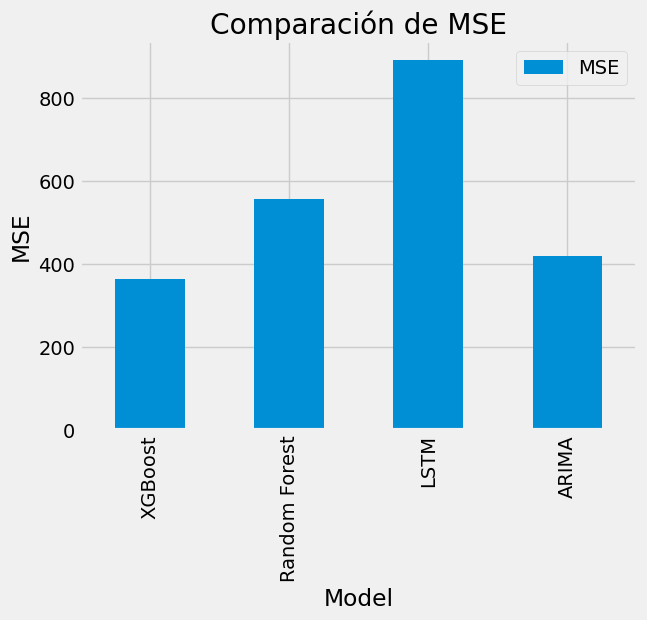

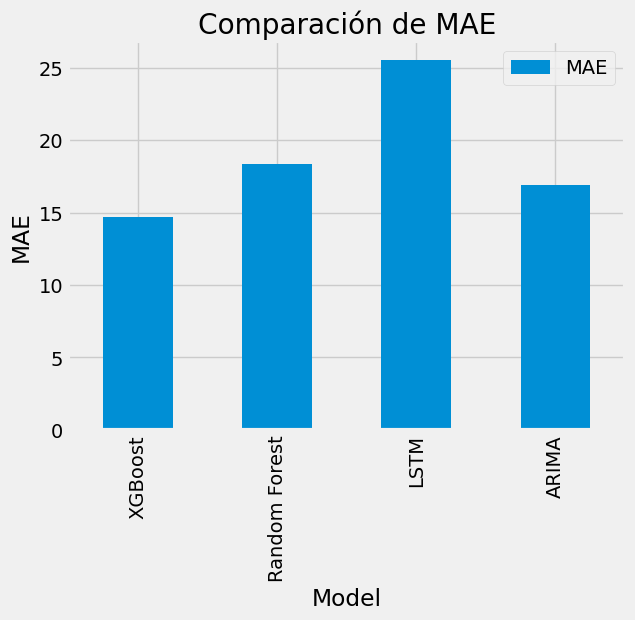

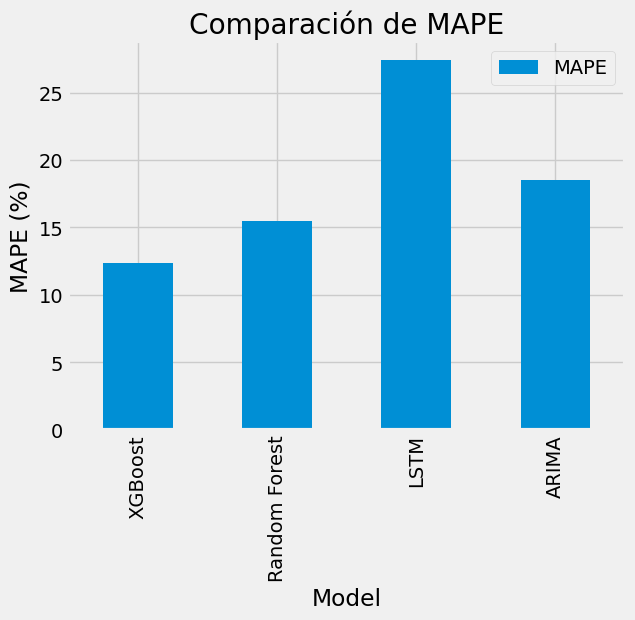

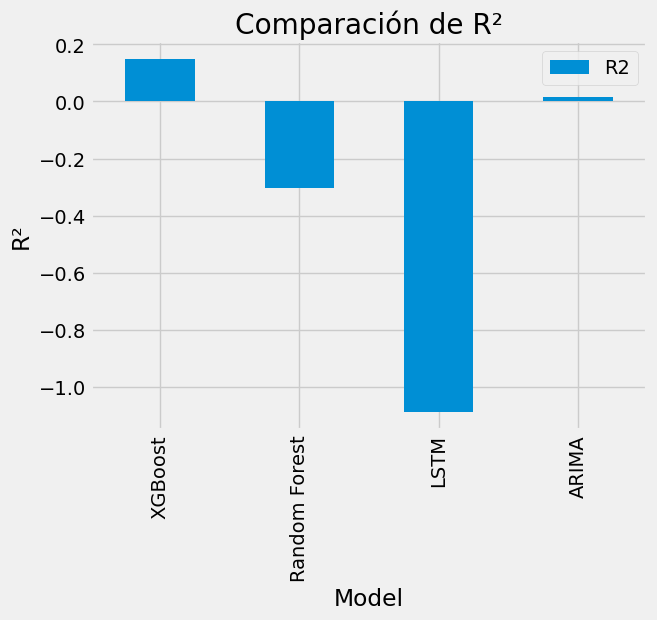

In [42]:
import matplotlib.pyplot as plt

# Asegúrate de que metrics_df es el DataFrame que contiene todas las métricas de los modelos

# Visualización de MSE (Mean Squared Error)
metrics_df.plot(x='Model', y='MSE', kind='bar', title='Comparación de MSE')
plt.ylabel('MSE')
plt.show()

# Visualización de MAE (Mean Absolute Error)
metrics_df.plot(x='Model', y='MAE', kind='bar', title='Comparación de MAE')
plt.ylabel('MAE')
plt.show()

# Visualización de MAPE (Mean Absolute Percentage Error)
metrics_df.plot(x='Model', y='MAPE', kind='bar', title='Comparación de MAPE')
plt.ylabel('MAPE (%)')
plt.show()

# Visualización de R² (Coeficiente de Determinación)
metrics_df.plot(x='Model', y='R2', kind='bar', title='Comparación de R²')
plt.ylabel('R²')
plt.show()


In [46]:
# Importaciones necesarias
import pandas as pd
import time

# Código para visualizar parámetros iniciales y resultados de búsqueda

# Resultados de búsqueda de XGBoost
print("Resultados de búsqueda de hiperparámetros para XGBoost:")
print("Mejores parámetros: ", best_params_xgb)
print("MSE: ", xgb_metrics['MSE'])
print("MAE: ", xgb_metrics['MAE'])
print("MAPE: ", xgb_metrics['MAPE'])
print("R²: ", xgb_metrics['R2'])
print("\n")

# Resultados de búsqueda de Random Forest
print("Resultados de búsqueda de hiperparámetros para Random Forest:")
print("Mejores parámetros: ", best_params_rf)
print("MSE: ", rf_metrics['MSE'])
print("MAE: ", rf_metrics['MAE'])
print("MAPE: ", rf_metrics['MAPE'])
print("R²: ", rf_metrics['R2'])
print("\n")

# Resultados para LSTM
print("Resultados para LSTM:")
print("MSE: ", lstm_metrics['MSE'])
print("MAE: ", lstm_metrics['MAE'])
print("MAPE: ", lstm_metrics['MAPE'])
print("R²: ", lstm_metrics['R2'])
print("\n")

# Resultados para ARIMA
print("Resultados para ARIMA:")
print("MSE: ", arima_metrics['MSE'])
print("MAE: ", arima_metrics['MAE'])
print("MAPE: ", arima_metrics['MAPE'])
print("R²: ", arima_metrics['R2'])
print("\n")

# Comparación final y selección del mejor modelo
print("Comparación final de modelos:")
print(metrics_df)

# Seleccionar el mejor modelo
best_model_name = metrics_df.sort_values(by='MSE').iloc[0]['Model']
print("\nMejor modelo según el MSE más bajo: ", best_model_name)

# Visualizaciones (opcional)
# Aquí puedes incluir el código de visualización de gráficos si lo consideras necesario


Resultados de búsqueda de hiperparámetros para XGBoost:
Mejores parámetros:  {'learning_rate': 0.23803499210851797, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 975, 'subsample': 0.7571172192068059}
MSE:  362.97797137522423
MAE:  14.696564101493653
MAPE:  12.372641550883046
R²:  0.15003543090384353


Resultados de búsqueda de hiperparámetros para Random Forest:
Mejores parámetros:  {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 485}
MSE:  557.0119439829657
MAE:  18.328270280489043
MAPE:  15.51306728042872
R²:  -0.30432272557796725


Resultados para LSTM:
MSE:  892.3626917967456
MAE:  25.567776111991925
MAPE:  27.447806702277234
R²:  -1.0895942195523505


Resultados para ARIMA:
MSE:  419.8487687899348
MAE:  16.912066011678455
MAPE:  18.4974721925422
R²:  0.016864366457124635


Comparación final de modelos:
           Model         MSE        MAE       MAPE        R2
0        XGBoost  362.977971  14.696564  12.372642  0.150035
1  Random Forest  